In [1]:
import torch
from torchvision import datasets as dsets
from torchvision import transforms

train_Data = dsets.MNIST(
    root='./data_mnist',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

#テストデータ
test_data = dsets.MNIST(
    root='./data_mnist',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

#訓練データ, 検証データ
train_data, valid_data = torch.utils.data.random_split(train_Data, [48000, 12000])


In [2]:
#load data
train_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

valid_loader = torch.utils.data.DataLoader(
    dataset=valid_data,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

In [3]:
from torch import nn
from torch.functional import F
from torch import optim

#MLP(隠れ層1, 784->512->10, relu)
class MLP(nn.Module):
    '''
    def __init__(self, D_in, H, D_out):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(D_in, H)
        self.l2 = nn.Linear(H,D_out)
        
    def forward(self, x):
        h = F.relu(self.l1(x))
        y = self.l2(x)
        return y
    '''
    
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28 * 1, 512)
        #self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        #self.dropout1 = nn.Dropout2d(0.2)
        #self.dropout2 = nn.Dropout2d(0.2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = self.dropout1(x)
        #x = F.relu(self.fc2(x))
        #x = self.dropout2(x)
        return self.fc3(x)
    
net = MLP()

#損失関数:交差エントロピー
criterion = nn.CrossEntropyLoss()
#最適化:SGD, 学習率0.01
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [4]:
#training

#50エポック繰り返す
num_epochs = 50

train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []
 
for epoch in range(num_epochs):
    train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0
    
    #train
    net.train()
    for inputs, labels in train_loader:
        inputs = inputs.view(-1, 28*28*1)
        optimizer.zero_grad()  #初期化
        outputs = net(inputs)  #出力
        loss = criterion(outputs, labels)  #損失関数
        train_loss += loss.item()
        acc = (outputs.max(1)[1] == labels).sum()
        train_acc += acc.item()
        loss.backward()  #逆伝播
        optimizer.step()  #重みの更新
    avg_train_loss = train_loss / len(train_loader.dataset)  # lossの平均を計算
    avg_train_acc = train_acc / len(train_loader.dataset)  # accの平均を計算
    
    #valid
    net.eval()
    with torch.no_grad():  #勾配の計算を停止
        for inputs, labels in valid_loader:
            inputs = inputs.view(-1, 28*28*1)
            outputs = net(inputs)  #出力
            loss = criterion(outputs, labels)  #損失関数
            val_loss += loss.item()
            acc = (outputs.max(1)[1] == labels).sum()
            val_acc += acc.item()
    avg_val_loss = val_loss / len(valid_loader.dataset)
    avg_val_acc = val_acc / len(valid_loader.dataset)
    
    # print log
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
 
    # append list for polt graph after training
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/50], Loss: 0.0204, val_loss: 0.0106, val_acc: 0.8431
Epoch [2/50], Loss: 0.0084, val_loss: 0.0072, val_acc: 0.8782
Epoch [3/50], Loss: 0.0065, val_loss: 0.0061, val_acc: 0.8930
Epoch [4/50], Loss: 0.0058, val_loss: 0.0056, val_acc: 0.9009
Epoch [5/50], Loss: 0.0054, val_loss: 0.0053, val_acc: 0.9038
Epoch [6/50], Loss: 0.0050, val_loss: 0.0050, val_acc: 0.9081
Epoch [7/50], Loss: 0.0048, val_loss: 0.0048, val_acc: 0.9117
Epoch [8/50], Loss: 0.0046, val_loss: 0.0046, val_acc: 0.9157
Epoch [9/50], Loss: 0.0044, val_loss: 0.0045, val_acc: 0.9190
Epoch [10/50], Loss: 0.0043, val_loss: 0.0043, val_acc: 0.9221
Epoch [11/50], Loss: 0.0041, val_loss: 0.0042, val_acc: 0.9243
Epoch [12/50], Loss: 0.0040, val_loss: 0.0040, val_acc: 0.9270
Epoch [13/50], Loss: 0.0039, val_loss: 0.0039, val_acc: 0.9294
Epoch [14/50], Loss: 0.0037, val_loss: 0.0038, val_acc: 0.9317
Epoch [15/50], Loss: 0.0036, val_loss: 0.0037, val_acc: 0.9324
Epoch [16/50], Loss: 0.0035, val_loss: 0.0036, val_acc: 0.9347
E

In [5]:
test_acc = 0

net.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.view(-1, 28*28*1)
        outputs = net(inputs)
        acc = (outputs.max(1)[1] == labels).sum()
        test_acc += acc.item()
    print('test_accuracy: {} %'.format(100 * test_acc / len(test_loader.dataset)))
        
torch.save(net.state_dict(), 'mlp_mnist.ckpt')  #モデルを保存

test_accuracy: 96.52 %


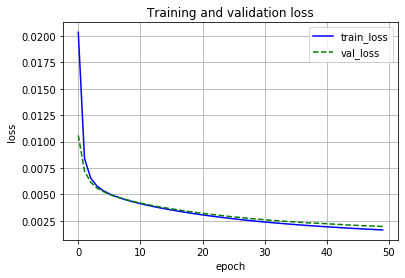

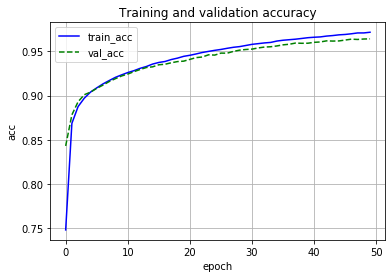

In [6]:
import matplotlib.pyplot as plt
 
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()
 
plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()